# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Семинар 4
## Сегментация


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
from torch.nn import BCEWithLogitsLoss
import numpy as np

import torchvision.transforms as tt
from PIL import Image
import os

import lightning.pytorch as pl
from torchmetrics.functional import accuracy
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output # для отчистки экрана

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

## 1. Релизация метрики IoU
Реализуйте метрику IoU. Она вам понадобится далее для оценивания результатов предсказания модели.

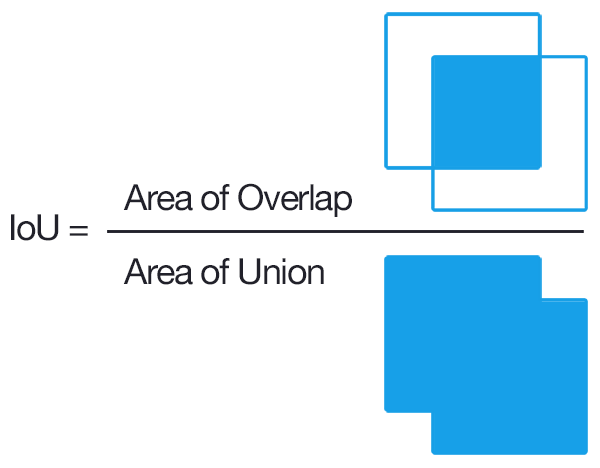

In [ ]:
def iou(predicted_mask_batch, target_mask_batch):
    """ Считает среднее IoU для всех элементов батча
    predicted_mask_batch - булев тензор размерности (batch_size, 1, H, W) - определяет предсказанную принадлежность пикселя к классу 1
    target_mask_batch - булев тензор размерности (batch_size, 1, H, W) - определяет реальную принадлежность пикселя к классу 1
    """
    # Площадь пересечения в пикселях для всех элементов батча
    intersection = <посчитайте пересечение с использованием операции &>
    # Площадь объединения в пикселях для всех элементов батча
    union =  <посчитайте пересечение с использованием операции | >
    # Посчитайте IoU для каждого элемента батча, а затем усредните по батчу
    iou = <ваш код>
    return iou

In [ ]:
predicted_mask_batch = torch.ones((1, 1, 10, 10)).bool()
target_mask_batch =  torch.ones((1, 1, 10, 10)).bool()
assert torch.allclose(iou(predicted_mask_batch, target_mask_batch), torch.tensor(1.0))

## 2. Сегментация изображений

Попробуем написать неглубокую сеть и сегментировать клетки рака груди. Более подробно про данные можно прочитать [тут:](https://www.kaggle.com/datasets/andrewmvd/breast-cancer-cell-segmentation)

Для этого напишем энкодер, который будет применять к входному изображению несколько свёрток, а затем напишем декодер, который по скрытому представлению будет разворачивать картинку с помощью обратных свёрток.

In [ ]:
!curl -JLO 'https://www.dropbox.com/scl/fi/gs3kzp6b8k6faf667m5tt/breast-cancer-cells-segmentation.zip?rlkey=md3mzikpwrvnaluxnhms7r4zn'
!unzip breast-cancer-cells-segmentation.zip

In [ ]:
IMAGES_PATH = 'Images'

MASKS_PATH = 'Masks'

Посмотрим на наши данные. Для этого напишем класс датасета:

In [ ]:
class CellsDataset(Dataset):
    def __init__(self, data_path, mask_path, aug=None):
        """
        Args:
            data_path: путь до изображений.
            mask_path: путь до масок изображений.
        """
        self.data_path = data_path
        self.mask_path = mask_path

        # Файлы с изображениями и масками
        self.files = list(filter(lambda f: f.endswith('.tif'), os.listdir(self.data_path)))
        self.mask_files = list(filter(lambda f: f.endswith('.TIF'), os.listdir(self.mask_path)))
        
        assert len(self.files) == len(self.mask_files)

        self.files.sort()
        self.mask_files.sort()

        # аугментация из albumentations
        self.aug = aug

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Загружаем изображение и маску
        file_name = os.path.join(self.data_path, self.files[idx])
        mask_name = os.path.join(self.mask_path, self.mask_files[idx])

        input = np.array(Image.open(file_name), dtype=np.uint8)
        target = np.array(Image.open(mask_name), dtype=np.uint8)

        # применяем аугментацию
        if self.aug:
            augmented = self.aug(image=input, mask=target)
            input = augmented['image']
            target = augmented['mask']
        
        # исправим порядок размерностей
        input = input.transpose(2, 0, 1)

        # Приводим к torch tensor
        input = torch.tensor(input, dtype=torch.float32)
        target = torch.from_numpy(target)

        target = (target > 0).int().unsqueeze(0)

        return input, target

Создайте датасет из всех данных.

При создании датасета передайте в него преобразование (аргумент aug), переводящее картинки в тензор с размерами 160 на 240. Вам можем помочь преобразование Resize из библиотеки albumentations.

In [ ]:
dataset = CellsDataset(<ваш код>)

Создадим тренировочный и валидационный датасеты:

In [ ]:
generator = torch.Generator().manual_seed(42)
indices = torch.randperm(len(dataset), generator=generator).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-14]) #создадим тренировочный датасет
val_dataset = torch.utils.data.Subset(dataset, indices[-14:-7]) #создадим валидационный датасет

Сколько изображений в каждом из полученных датасетов?

In [ ]:
<ваш код>

**Ответ**:

Посмотрим на данные:

In [ ]:
for i in range(5):
    plt.figure(figsize=(15, 7))
    
    sample = train_dataset[i]
    
    plt.subplot(1, 2, 1)
    plt.title("Изображение")
    plt.imshow(sample[0].permute(1, 2, 0).int())
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title("Маска")
    plt.imshow(sample[1].squeeze(), cmap='Greys_r')
    plt.axis("off");
    
    print("Значения в маске и количество значений:", np.unique(train_dataset[i][1], return_counts=True))

Теперь мы, наконец, готовы перейти к написанию энкодера!

Напишем энкодер с тремя слоями свёрток, на каждом слое будем уменьшать вдвое размер изображения.

*Подсказка: для получения нужных размеров изображений подберите подходящие разумные значения размера фильтра, padding и stride.*

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.conv1 = torch.nn.Sequential(
            <ваш код>
        ) # на вход получаем изображение 128x128x3, на выходе после свертки, функции активации и батч-нормализации - 64x64x32

        self.conv2 = torch.nn.Sequential(
            <ваш код>
        ) # на вход получаем изображен 64x64x32, на выходе после свертки, функции активации и батч-нормализации - 32x32x64

        self.conv3 = torch.nn.Sequential(
            <ваш код>
        ) # на вход получаем изображен 32x32x64, на выходе после свертки, функции активации и батч-нормализации - 16x16x128

    def forward(self, x):
        x = self.conv1(x) # 64 х 64
        x = self.conv2(x) # 32 х 32
        x = self.conv3(x) # 16 х 16
        return x

С помощью операции обратной свёртки напишем декодер из трёх слоёв, на каждом из которых размер картинки на выходе будет соответствовать картинке в энкодере. Не забудем добавить нормализацию как в обычной сверточной сети.

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.convt1 = torch.nn.Sequential(
            <ваш код>,
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(<ваш код>)
        ) # 16x16x128 -> 32x32x64

        self.convt2 = torch.nn.Sequential(
            <ваш код>,
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(<ваш код>)
        )  # 32x32x64 -> 64x64x32

        self.convt3 = torch.nn.Sequential(
            <ваш код>,
            torch.nn.Sigmoid()
        )  # 64x64x32 -> 128x128x3

    def forward(self, z, test=False):
        z = self.convt1(z)
        if test:
            print(z.shape)

        z = self.convt2(z)
        if test:
            print(z.shape)

        z = self.convt3(z)
        if test:
            print(z.shape)

        return z

Соединяем всё в одну сеть и запустим процесс обучения.

In [ ]:
class Segmentation(torch.nn.Module):
    def __init__(self):
        super(Segmentation, self).__init__()
        self.enc = <ваш код>
        self.dec = <ваш код>

    def forward(self, x):
        z = self.enc(x)
        res = self.dec(z)
        return res

Обернем модель в lightningmodule. Поскольку выход сети будет говорить для каждого пикселя вероятность быть частью маски (насколько пиксель белый), то в качестве функции потерь возьмём попиксельную кросс-энтропию. Так как модель возвращает логиты, возьмем BCEWithLogitsLoss.

In [ ]:
class SegmentationModel(pl.LightningModule):
    def __init__(self, lr=2e-3):
        '''Инициализирует модуль
        * layer_widths -- список размерностей скрытых слоев в U-Net'''
        super().__init__()
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        self.save_hyperparameters()
        self.model = Segmentation()
        self.predictions = []
        self.metric = iou

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def forward(self, x):
        return self.model(x)

    def __step(self, batch, name):
        ''' Описывает 1 шаг обучения на batch
        * name -- либо train, либо val'''
        images, target = batch
        output = <получите предсказание с помощью модели>
        loss = <посчитайте лосс> #обратите внимание, какого типа должны быть данные в тензорах?
        iou = self.metric(output > 0, target > 0)
        self.log(name+'_loss', loss)
        self.log(name+'_iou', iou, on_step=False, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.__step(<ваш код>)

    def validation_step(self, batch, batch_idx):
        return self.__step(<ваш код>)

Создадим даталоадеры

In [ ]:
batch_size = 4

train_sampler = torch.utils.data.RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

Объявим trainer и обучим на 50 эпохах:

In [ ]:
model = SegmentationModel()
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_iou', mode='max')
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/simple_encoder_decoder")
trainer = pl.Trainer(<ваш код>)

In [ ]:
trainer.fit(<ваш код>)

Напишем функцию для визуализации процесса обучения. Она будет выводить 4 колонки картинок: изображение, его маску, предсказанную моделью маску, логиты модели.

In [ ]:
def vis_dataset(val_dataset, segment_model, n_img=4, savefig_dir=None):
    plt.figure(figsize=(20, n_img * 3.5))

    for i, (image, mask) in enumerate(val_dataset):
        if i == n_img:
            break

        plt.subplot(n_img, 4, 4 * i + 1)
        plt.imshow(image.permute(1, 2, 0).cpu().int())
        plt.axis("off")
        plt.title("Изображение")

        plt.subplot(n_img, 4, 4 * i + 2)
        plt.imshow(mask.squeeze().cpu())
        plt.axis("off")
        plt.title("Реальная маска")

        with torch.no_grad():
            pred = segment_model(image.unsqueeze(dim=0).to(device)).squeeze().cpu()

        plt.subplot(n_img, 4, 4 * i + 3)
        plt.imshow(pred > 0.)
        plt.axis("off")
        plt.title("Предсказанная маска")

        plt.subplot(n_img, 4, 4 * i + 4)
        plt.imshow(pred)
        plt.axis("off")
        plt.title("Логиты")

    plt.show()

Посмотрим на результаты

In [ ]:
# Отрисовка результатов
vis_dataset(val_dataset, model, n_img=4, savefig_dir=None)

Каких результатов удалось достичь с помощью неглубокой сети? Напишите вывод по графику и примерам изображения.

**Вывод**: